In [ ]:
pip install fastf1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires websockets>=14.0, but you have websockets 13.1 which is incompatible.
google-adk 1.14.1 requires websockets<16.0.0,>=15.0.1, but you have websockets 13.1 which is incompatible.


In [ ]:
import os
import pandas as pd
import re
import logging
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
from matplotlib import colormaps
import fastf1 as ff1
import fastf1.plotting
import kagglehub
import folium
import math
import warnings
from google.colab import drive
import unicodedata
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Suppress warnings for cleaner output
logging.getLogger("fastf1").setLevel(logging.ERROR)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Enable caching
cache_dir = "/content/CacheFormulaOne"
os.makedirs(cache_dir, exist_ok=True)
fastf1.Cache.enable_cache(cache_dir)

In [ ]:
# print names of all the weekends and drivers available
schedule = ff1.get_event_schedule(year)
print("Available Weekends:")
for index, row in schedule.iterrows():
    print(row['EventName'])

# To get drivers, you would typically load a session and then access the drivers from the laps data
# Example (requires loading a session first):
# session = ff1.get_session(year, wknd, ses)
# session.load()
# drivers = pd.unique(session.laps['Driver'])
# print("\nAvailable Drivers in the loaded session:")
# for driver in drivers:
#     print(driver)

Available Weekends:
Pre-Season Testing
Bahrain Grand Prix
Saudi Arabian Grand Prix
Australian Grand Prix
Japanese Grand Prix
Chinese Grand Prix
Miami Grand Prix
Emilia Romagna Grand Prix
Monaco Grand Prix
Canadian Grand Prix
Spanish Grand Prix
Austrian Grand Prix
British Grand Prix
Hungarian Grand Prix
Belgian Grand Prix
Dutch Grand Prix
Italian Grand Prix
Azerbaijan Grand Prix
Singapore Grand Prix
United States Grand Prix
Mexico City Grand Prix
São Paulo Grand Prix
Las Vegas Grand Prix
Qatar Grand Prix
Abu Dhabi Grand Prix


In [ ]:

year = 2024
wknd = "São Paulo Grand Prix"
ses = 'R'
driver = 'VER'


session = ff1.get_session(year, wknd, ses)
weekend = session.event
session.load()

print(session.event.EventName)
print(session.event.EventDate)

São Paulo Grand Prix
2024-11-03 00:00:00


In [ ]:
fastest_lap = session.laps.pick_driver(driver).pick_fastest()
lap = fastest_lap

print(fastest_lap)

telemetry = fastest_lap.get_car_data().add_distance()

# Get positional data and reset index
pos_data = fastest_lap.get_pos_data().reset_index(drop=True)
pos = pos_data

# Merge telemetry with positional data
telemetry = telemetry.merge(pos_data, left_index=True, right_index=True, how="left")

#print(telemetry)
# x and y position of the car
x = np.array(telemetry['X'].values)
y = np.array(telemetry['Y'].values)


# get points and rotate them according to the correct layout orientation
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)


Time                      0 days 03:16:06.655000
Driver                                       VER
DriverNumber                                   1
LapTime                   0 days 00:01:20.472000
LapNumber                                   67.0
Stint                                        2.0
PitOutTime                                   NaT
PitInTime                                    NaT
Sector1Time               0 days 00:00:20.546000
Sector2Time               0 days 00:00:42.236000
Sector3Time               0 days 00:00:17.690000
Sector1SessionTime        0 days 03:15:06.729000
Sector2SessionTime        0 days 03:15:48.965000
Sector3SessionTime        0 days 03:16:06.655000
SpeedI1                                    305.0
SpeedI2                                    240.0
SpeedFL                                    307.0
SpeedST                                    274.0
IsPersonalBest                              True
Compound                            INTERMEDIATE
TyreLife            

In [ ]:

# Get circuit info
circuit_info = session.get_circuit_info()

print(circuit_info)

#corners
corners = circuit_info.corners

def rotate(xy, *, angle):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)],
                        [-np.sin(angle), np.cos(angle)]])
    return np.matmul(xy, rot_mat)

# Rotate track based on circuit info
track = pos.loc[:, ('X', 'Y')].to_numpy()
track_angle = circuit_info.rotation / 180 * np.pi
rotated_track = rotate(track, angle=track_angle)

rotated_segments = []
for segment in segments:
    rotated_segment = [rotate([x, y], angle=track_angle) for x, y in segment]
    rotated_segments.append(rotated_segment)


#gear
gear = telemetry['nGear'].to_numpy().astype(float)

#speed
speed = lap.telemetry['Speed']

#throttle
throttle = lap.telemetry["Throttle"]

#angle of corners
corner_angles = circuit_info.corners['Angle']



CircuitInfo(corners=              X            Y  Number Letter       Angle     Distance
0  -2393.436279 -8518.955078       1         -87.791757   352.152169
1  -1548.525146 -8083.349121       2         -94.168976   451.108353
2    225.649078 -8132.426758       3         -58.645126   649.168770
3   2323.666016 -1064.507935       4          30.204598  1388.879784
4    821.303650  -714.728210       5         101.230218  1544.817155
5  -2024.531128 -3964.448486       6         -63.591039  2001.072259
6  -3261.284668 -3714.666016       7          38.702878  2139.269496
7  -3523.720703 -2188.385254       8         148.838437  2294.985607
8  -2383.048340 -2240.020996       9         -54.666534  2424.820294
9  -3075.818115   258.466919      10         118.470247  2714.880097
10 -1368.580200  -706.139099      11          93.567408  2927.965947
11   140.721786  1484.997314      12        -146.185085  3216.084494
12  -871.737366  1881.447021      13          86.786511  3319.913146
13 -3189.64160

In [ ]:
# Define thresholds for classification
# Define specific thresholds for Monaco or similar circuits
chicane_distance_thresh = 300  # Example threshold for chicane
chicane_angle_thresh = 60  # Example angle threshold for chicane (sharp turn)
chicane_speed_thresh = 80  # Minimum speed to consider (might be adjusted for Monaco)
hairpin_angle_thresh = 45  # Example threshold for hairpins (sharpest turn) # Speed threshold for low-speed corners
high_speed_thresh = 200  # km/h (High-Speed Segment)
medium_speed_thresh = 150  # km/h (Medium-Speed Corner)
low_speed_thresh = 70  # km/h (Low-Speed Corner and Hairpins)
braking_speed_drop = 10  # Speed drop threshold for braking zones

# Define corner angle thresholds for classification
corner_angle_thresh_sharp = 60  # Degrees (Hairpins)
corner_angle_thresh_wide = 120  # Degrees (High-Speed Corners)

# Initialize all segments as "Unknown"
telemetry["segment"] = "Unknown"

# Step 1: Classify Braking Zones based on significant speed drops
telemetry["Speed Drop"] = telemetry["Speed"].diff()  # Calculate speed drop between consecutive points
telemetry["Gear Drop"] = telemetry["nGear"].diff()  # Detect gear shifts

# Braking Zones are characterized by a significant speed drop and gear shift (downshift)
telemetry.loc[(telemetry["Speed Drop"] < -braking_speed_drop) & (telemetry["Gear Drop"] < 0), "segment"] = "Braking Zone"

# Step 2: Classify High-Speed Segments (straightaways and high-speed corners)
# High-Speed Segment (straight line or high-speed corners with throttle)
telemetry.loc[(telemetry["Speed"] > high_speed_thresh) & (telemetry["Throttle"] > 50), "segment"] = "High-Speed Segment"

# Step 3: Classify Low-Speed Corners based on speed (Hairpins)
# Hairpins typically have very low speeds (below 50 km/h) and sharp angles
for i, row in telemetry.iterrows():
    x, y = row["X"], row["Y"]

    # Find the closest corner by comparing (x, y) to the corner positions
    closest_corner = None
    min_dist = float('inf')

    # Loop through each corner to find the closest match
    for j, corner in circuit_info.corners.iterrows():
        corner_x, corner_y = corner["X"], corner["Y"]  # Assuming corner positions are available
        distance = np.sqrt((x - corner_x)**2 + (y - corner_y)**2)

        if distance < min_dist:
            min_dist = distance
            closest_corner = corner

    # Get the angle of the closest corner
    if closest_corner is not None:
        corner_angle = closest_corner["Angle"]

        # Classify Hairpins as corners with sharp angles and very low speeds
        if corner_angle < corner_angle_thresh_sharp and row["Speed"] < low_speed_thresh:
            telemetry.at[i, "segment"] = "Hairpin"

# Step 4: Classify Medium-Speed Corners based on speed and corner angle
telemetry.loc[(telemetry["Speed"] >= medium_speed_thresh) & (telemetry["Speed"] <= high_speed_thresh), "segment"] = "Medium-Speed Corner"

# Step 5: Classify High-Speed Corners based on speed and wide angles
for i, row in telemetry.iterrows():
    x, y = row["X"], row["Y"]

    # Find the closest corner by comparing (x, y) to the corner positions
    closest_corner = None
    min_dist = float('inf')

    # Loop through each corner to find the closest match
    for j, corner in circuit_info.corners.iterrows():
        corner_x, corner_y = corner["X"], corner["Y"]  # Assuming corner positions are available
        distance = np.sqrt((x - corner_x)**2 + (y - corner_y)**2)

        if distance < min_dist:
            min_dist = distance
            closest_corner = corner

    # Get the angle of the closest corner
    if closest_corner is not None:
        corner_angle = closest_corner["Angle"]

        # Classify High-Speed Corners as corners with wide angles and high speed
        if corner_angle > corner_angle_thresh_wide and row["Speed"] > high_speed_thresh:
            telemetry.at[i, "segment"] = "High-Speed Corner"

# Step 6: Classify Straight Segments
straight_speed_thresh = 250  # km/h (Minimum speed for straight segments)
throttle_thresh = 50  # Throttle percentage (minimum throttle for straight)
min_straight_length = 3  # Minimum number of consecutive data points to classify as straight

for i in range(min_straight_length, len(telemetry)):
    # Check if speed is consistently high and throttle is also high (no significant drops)
    if all(telemetry.loc[i-j, 'Speed'] > straight_speed_thresh and telemetry.loc[i-j, 'Throttle'] > throttle_thresh for j in range(min_straight_length)):
        telemetry.at[i, 'segment'] = 'Straight'

    # If the segment has speed below threshold, mark it as "Braking Zone" or another category
    elif telemetry.loc[i, 'Speed'] < straight_speed_thresh:
        telemetry.at[i, 'segment'] = 'Braking Zone'

# Step 7: Final Check: Ensure that high-speed segments do not get marked as braking zones or low-speed corners
telemetry.loc[telemetry["segment"] == "Unknown", "segment"] = "Straight"


# Define thresholds for chicane detection
chicane_distance_thresh = 100  # Maximum distance between consecutive corners in meters
chicane_angle_thresh = 60  # Sharp turn angle (degrees) for chicanes
chicane_speed_thresh = 150  # Speed threshold for chicanes (medium to high speed)

## Step 8: Classify Chicanes, Hairpins, and Low-Speed Corners based on sharp turns and speed
for i in range(1, len(telemetry) - 1):  # Start at 1 and end at len-2 to avoid index errors
    x, y = telemetry.loc[i, ["X", "Y"]]

    # Avoid out-of-bounds errors: handle previous and next corner indices
    prev_index = i - 1 if i - 1 >= 0 else None
    next_index = i + 1 if i + 1 < len(circuit_info.corners) else None

    # If there's no previous or next corner, skip this iteration
    if prev_index is None or next_index is None:
        continue

    # Get previous and next corners based on valid indices
    prev_corner = circuit_info.corners.iloc[prev_index]
    next_corner = circuit_info.corners.iloc[next_index]

    # Calculate distances between consecutive points (current, previous, next)
    dist_prev = np.sqrt((x - prev_corner["X"])**2 + (y - prev_corner["Y"])**2)
    dist_next = np.sqrt((x - next_corner["X"])**2 + (y - next_corner["Y"])**2)

    # Check for sharp turns and close distances between consecutive corners
    if dist_prev < chicane_distance_thresh and dist_next < chicane_distance_thresh:
        prev_angle = prev_corner["Angle"]
        next_angle = next_corner["Angle"]

        # Check if both previous and next corners have sharp angles
        if prev_angle < chicane_angle_thresh and next_angle < chicane_angle_thresh and telemetry.loc[i, "Speed"] > chicane_speed_thresh:
            telemetry.at[i, "segment"] = "Chicane"
        # Check for Hairpins: Sharp angle (less than 45 degrees) and low speed
        elif prev_angle < hairpin_angle_thresh and next_angle < hairpin_angle_thresh and telemetry.loc[i, "Speed"] < low_speed_thresh:
            telemetry.at[i, "segment"] = "Hairpin"
        # Check for low-speed corners: Sharp turn and low speed
        elif prev_angle < chicane_angle_thresh and next_angle < chicane_angle_thresh and telemetry.loc[i, "Speed"] < low_speed_thresh:
            telemetry.at[i, "segment"] = "Low-Speed Corner"


# Check if chicane segments were classified correctly
print(telemetry[telemetry["segment"] == "Chicane"])


# Calculate average speed per segment for better performance analysis
segment_performance = telemetry.groupby("segment")["Speed"].mean().reset_index()
print(segment_performance)

# Compute max speed in straights (max straight-line speed from the fastest lap)
straight_speed = fastest_lap["SpeedST"]
print(f"Straight-Line Speed: {straight_speed:.2f} km/h")

# Number of entries per segment for understanding
segment_counts = telemetry["segment"].value_counts()
print(segment_counts)

# Save telemetry data with classifications to CSV
telemetry.to_csv('telemetry_with_segments.csv', index=True)


Empty DataFrame
Columns: [Date_x, RPM, Speed, nGear, Throttle, Brake, DRS, Source_x, Time_x, SessionTime_x, Distance, Date_y, Status, X, Y, Z, Source_y, Time_y, SessionTime_y, segment, Speed Drop, Gear Drop]
Index: []

[0 rows x 22 columns]
              segment       Speed
0        Braking Zone  152.103286
1  High-Speed Segment  270.700000
2            Straight  287.851351
Straight-Line Speed: 274.00 km/h
segment
Braking Zone          213
Straight               74
High-Speed Segment     10
Name: count, dtype: int64


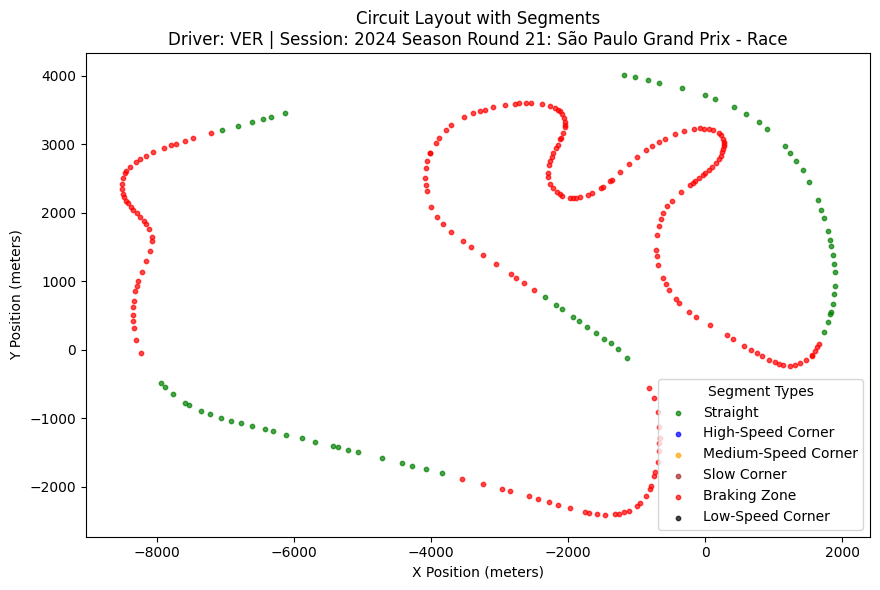

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms  # Import mtransforms
import numpy as np

# Define color mapping for each segment type
segment_colors = {
    "Straight": "green",  # For straight segments
    "High-Speed Corner": "blue",  # For high-speed corners
    "Medium-Speed Corner": "orange",  # For medium-speed corners
    "Slow Corner": "brown",  # For slow corners
    "Braking Zone": "red", # For braking zones,
    "Low-Speed Corner": "black"  # For low-speed corners
}


# Define the rotation function
def rotate(points, angle):
    """ Rotate a list of points (X, Y) by a given angle in degrees. """
    angle_rad = np.deg2rad(angle)
    rotation_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                                [np.sin(angle_rad), np.cos(angle_rad)]])
    return np.dot(points, rotation_matrix)

# Assume 'telemetry' contains the data and 'segment_colors' is defined as before
# Rotate the circuit layout (X, Y)
track_angle_new = 0  # Example rotation angle, you can modify this as needed
rotated_track = rotate(np.array([telemetry["X"], telemetry["Y"]]).T, track_angle_new)

# Create a new figure for the segments visualization with circuit overlay
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the rotated circuit layout in black
#ax.plot(rotated_track[:, 0], rotated_track[:, 1], color="black", linewidth=2, label="Circuit Layout")


track_angle_new = 0 # Rotate by 90 degrees


# Plot the segments with different colors on top of the rotated circuit layout
for segment, color in segment_colors.items():
    # Get the indices where the segment matches the condition
    segment_indices = telemetry[telemetry["segment"] == segment].index
    # Rotate the segment points
    rotated_segment = rotate(np.array([telemetry["X"].iloc[segment_indices], telemetry["Y"].iloc[segment_indices]]).T, track_angle_new)
    # Plot the rotated segment points on the circuit layout
    ax.scatter(rotated_segment[:, 1], -rotated_segment[:, 0], color=color, label=segment, s=10, alpha=0.7)


ax.set_aspect('equal')



# Set plot title with driver and session info
driver_name = driver  # Assuming the driver name is constant across rows
session_info = session  # Assuming session info is constant across rows
ax.set_title(f"Circuit Layout with Segments\nDriver: {driver_name} | Session: {session_info}")

# Add labels and legend
ax.set_xlabel("X Position (meters)")
ax.set_ylabel("Y Position (meters)")
ax.legend(title="Segment Types")

# Adjust layout for better spacing
plt.tight_layout()

#rotate the plot 90 degree

plt.show()


